# **NLP Project 2 : Supervised Learning**
## Léo RINGEISSEN and Santiago MARTIN

# Library Importations

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Data Import and Aggregation
## Description:
This section imports all Excel files, combines them into a single DataFrame, and selects relevant columns for further processing.
### Justification:
Aggregating all files upfront ensures consistent preprocessing. We select relevant columns (`rating`, `product`, `type`, and `review`) for the supervised learning task.

In [19]:
# Step 1: Gather all Excel file paths
file_paths = glob.glob("Traduction avis clients/*.xlsx")

# Step 2: Load and combine files
dataframes = []
for file in file_paths:
    df = pd.read_excel(file)
    dataframes.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Select relevant columns
selected_columns = ["note", "produit", "type", "avis_en"]  # French column names
combined_df = combined_df[selected_columns]

# Rename columns to English
combined_df.columns = ["rating", "product", "type", "review"]

# Manual Translation of `product` Column
## Description:
Manually translate the values in the `product` column to English using predefined mappings.
### Justification:
Standardizing product names ensures uniformity and facilitates downstream analysis.

In [20]:
# Correct product translations
product_translations = {
    "animaux": "animals",
    "auto": "car",
    "credit": "credit",
    "garantie-decennale": "ten-year warranty",
    "habitation": "home",
    "moto": "motorcycle",
    "multirisque-professionnelle": "professional multi-risk",
    "prevoyance": "accidental injury",
    "responsabilite-civile-professionnelle": "professional liability",
    "sante": "health",
    "vie": "life"
}

# Apply translations to `product` column
combined_df["product"] = combined_df["product"].map(product_translations)

# Clean English Reviews
## Description:
Process the `review` column to:
1. Remove faulty reviews containing "Loading...".
2. Ensure reviews are stripped of extra spaces and line breaks, leaving clean single-line reviews.
### Justification:
Removing faulty reviews and standardizing formatting enhances data quality and improves model performance.

In [21]:
# Remove faulty reviews and clean the text
combined_df["review"] = (
    combined_df["review"]
    .str.replace(r"\s+", " ", regex=True)  # Replace extra spaces and newlines with a single space
    .str.strip()  # Remove leading/trailing spaces
)

# Filter out rows with "Loading..."
combined_df = combined_df[~combined_df["review"].str.contains("Loading...", na=False)]

# Removing null values (focus on ratings)
## Description:
We're going to remove rows with null values
1. The data of type `test` don't have ratings, which problematic for a supervised learning task
2. There are also other columns with null values, which can't be exploited
### Justification:
Removing faulty rows enhances data quality and improves model performance.

In [22]:
print(combined_df.isnull().sum())
combined_df.dropna(inplace=True)
print(combined_df.isnull().sum())

rating     9782
product      16
type          0
review        2
dtype: int64
rating     0
product    0
type       0
review     0
dtype: int64


# Summary of Cleaned Data
## Description:
Display a summary of the cleaned dataset, including:
1. The total number of rows and columns.
2. A count of unique products, ratings, and ratings-product combos, along with their their distribution.
3. The first few rows to verify correctness.
### Justification:
This step ensures the preprocessing pipeline has produced a clean and structured dataset.

In [23]:
print("Total rows and columns:", combined_df.shape)

Total rows and columns: (23539, 4)



Unique ratings and counts:
rating
1.0    7094
4.0    4771
5.0    4745
2.0    3635
3.0    3294
Name: count, dtype: int64


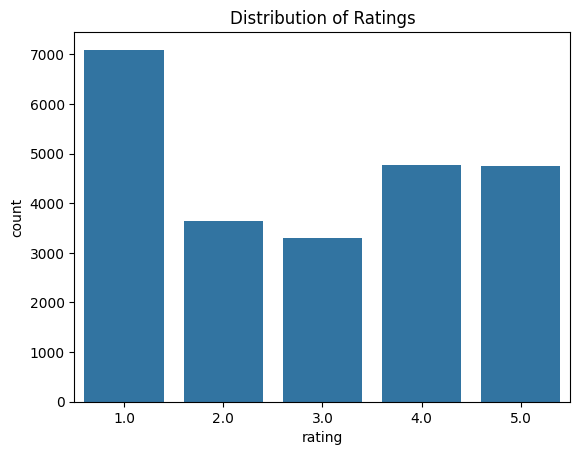

In [24]:
print("\nUnique ratings and counts:")
print(combined_df["rating"].value_counts())

sns.countplot(x="rating", data=combined_df)
plt.title("Distribution of Ratings")
plt.show()


Unique product categories and counts:
product
car                        13745
health                      3443
motorcycle                  2063
home                        1922
accidental injury            768
credit                       640
life                         559
animals                      364
professional multi-risk       19
ten-year warranty             11
professional liability         5
Name: count, dtype: int64


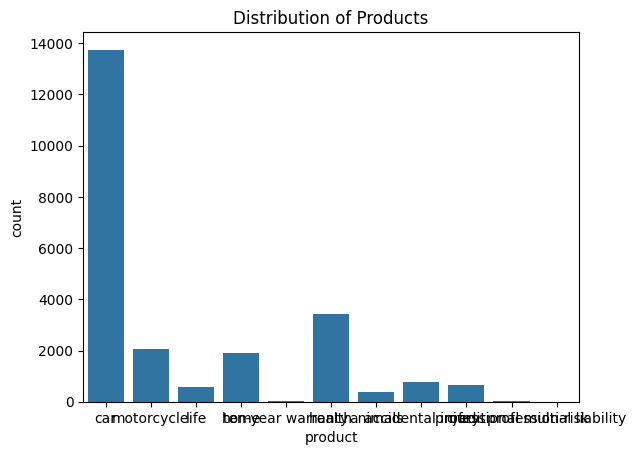

In [25]:
print("\nUnique product categories and counts:")
print(combined_df["product"].value_counts())

sns.countplot(x="product", data=combined_df)
plt.title("Distribution of Products")
plt.show()


Count of products per rating:
rating  product                
1.0     car                        2948
        health                     1381
        home                       1054
        accidental injury           506
        life                        395
        motorcycle                  309
        credit                      265
        animals                     214
        ten-year warranty             9
        professional multi-risk       8
        professional liability        5
2.0     car                        2049
        home                        526
        health                      431
        motorcycle                  264
        accidental injury           115
        credit                       95
        life                         84
        animals                      70
        professional multi-risk       1
3.0     car                        2096
        health                      522
        motorcycle                  263
        home     

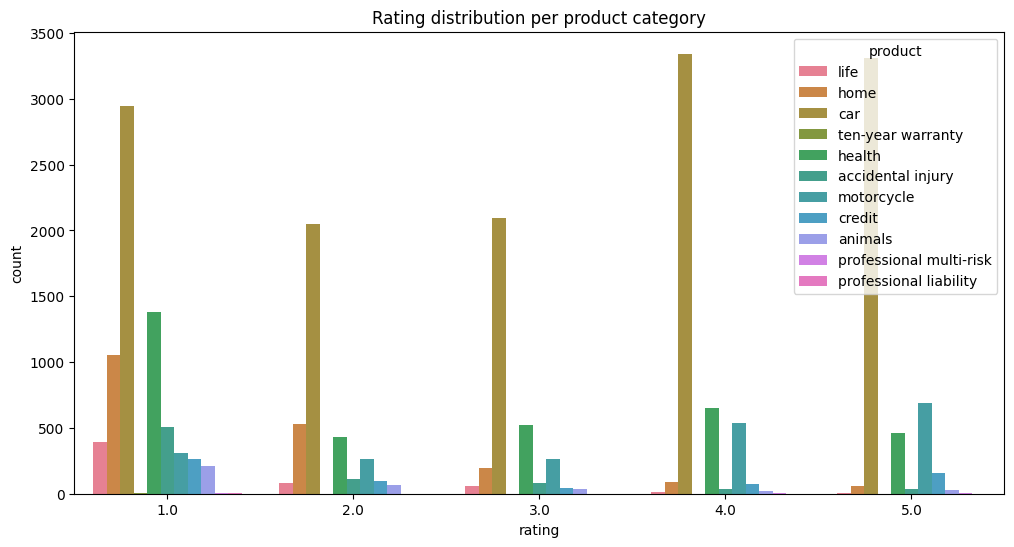

In [26]:
print("\nCount of products per rating:")
print(combined_df.groupby("rating")["product"].value_counts())

plt.figure(figsize=(12, 6))
sns.countplot(data=combined_df, x="rating", hue="product")
plt.title("Rating distribution per product category")
plt.show()

In [27]:
print("\nSample data:")
display(combined_df.head())


Sample data:


,rating,product,type,review
0,4.0,car,train,The person on the phone was clear and friendly...
1,4.0,motorcycle,train,"Satisfied. Reactivity, simplicity. Attractive ..."
2,1.0,life,train,"Insurer to flee, does not ensure its responsib..."
3,1.0,home,train,The GMF has been waiting for a water damage fo...
4,3.0,car,train,I am good with this insurance. She is practica...


In [28]:
combined_df.to_csv("combined_reviews.csv", index=False)
df = combined_df.copy()

# Exploratory Data Analysis and Word Frequency
In this section, we'll analyze the cleaned text reviews to highlight frequent words and n-grams. This helps us understand the data distribution and potential features for model building.

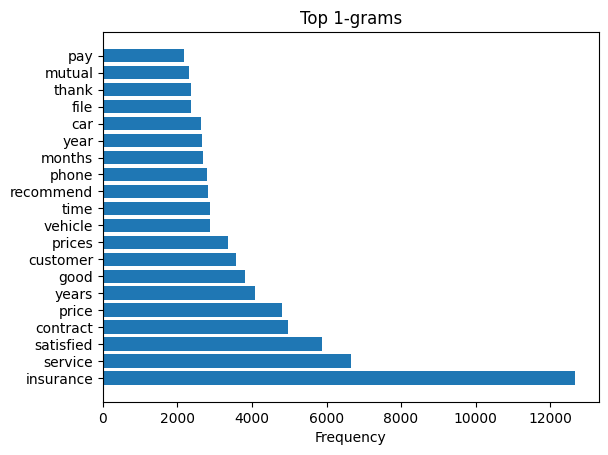

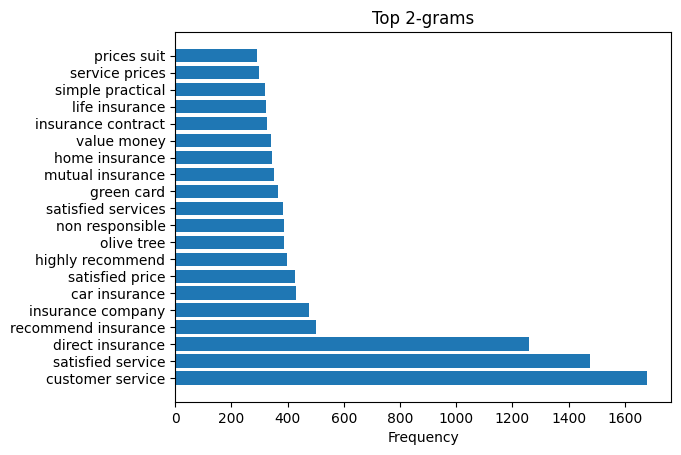

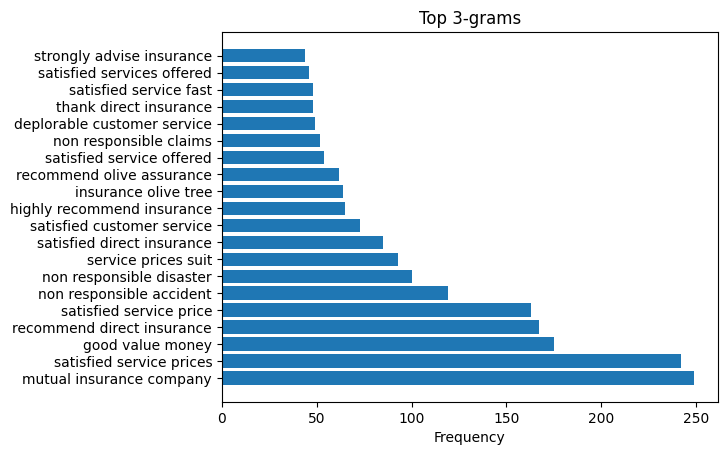

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate n-grams
def plot_ngrams(reviews, n=1, top_n=20):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_counts = vectorizer.fit_transform(reviews)
    ngram_freq = ngram_counts.sum(axis=0).A1
    ngram_words = vectorizer.get_feature_names_out()
    ngram_data = sorted(zip(ngram_freq, ngram_words), reverse=True)[:top_n]
    
    plt.barh([x[1] for x in ngram_data], [x[0] for x in ngram_data])
    plt.xlabel("Frequency")
    plt.title(f"Top {n}-grams")
    plt.show()

# Plot frequent words and bigrams
plot_ngrams(df['review'], n=1)  # Unigrams
plot_ngrams(df['review'], n=2)  # Bigrams
plot_ngrams(df['review'], n=3)  # Trigrams

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(df['review']))

# Predicting Ratings Using Classical ML Models
This section focuses on predicting star ratings using text reviews. We'll extract TF-IDF features and train models like Logistic Regression and Random Forest. The performance will be evaluated using metrics such as accuracy, F1-score, and confusion matrix.

Classification Report for Ratings:
              precision    recall  f1-score   support

         1.0       0.62      0.88      0.72      1450
         2.0       0.36      0.17      0.23       713
         3.0       0.35      0.17      0.22       674
         4.0       0.47      0.49      0.48       939
         5.0       0.58      0.61      0.59       932

    accuracy                           0.54      4708
   macro avg       0.47      0.46      0.45      4708
weighted avg       0.50      0.54      0.50      4708



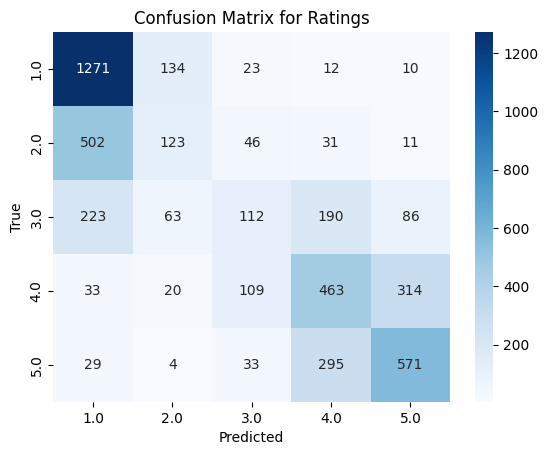

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# TF-IDF Feature Extraction
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['review'])
y_ratings = df['rating']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_ratings, test_size=0.2, random_state=42)

# Logistic Regression for Ratings
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluation
print("Classification Report for Ratings:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Ratings")
plt.show()

# Predicting Product Categories Using Classical ML Models
In this section, we predict the product category associated with each review. We'll use TF-IDF for feature extraction and train models like Logistic Regression and Random Forest. The evaluation focuses on metrics such as accuracy and confusion matrices.

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report for Products:
                         precision    recall  f1-score   support

      accidental injury       0.80      0.37      0.51       154
                animals       1.00      0.16      0.28        75
                    car       0.73      0.98      0.84      2679
                 credit       0.84      0.22      0.34       120
                 health       0.82      0.74      0.78       690
                   home       0.84      0.44      0.58       427
                   life       0.84      0.40      0.54       129
             motorcycle       0.92      0.26      0.41       427
 professional liability       0.00      0.00      0.00         1
professional multi-risk       0.00      0.00      0.00         4
      ten-year warranty       0.00      0.00      0.00         2

               accuracy                           0.76      4708
              macro avg       0.62      0.32      0.39      4708
           weighted avg       0.78      0.76      0.

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

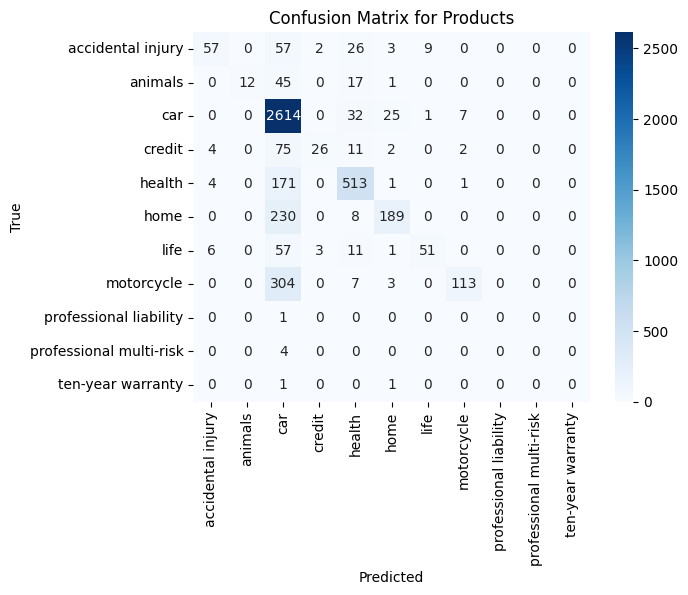

In [31]:
# Labels for Products
y_products = df['product']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_products, test_size=0.2, random_state=42)

# Logistic Regression for Products
lr_product = LogisticRegression(max_iter=1000, multi_class="ovr")
lr_product.fit(X_train, y_train)
y_pred_product = lr_product.predict(X_test)

# Evaluation
print("Classification Report for Products:")
print(classification_report(y_test, y_pred_product))

# Confusion Matrix
cm_product = confusion_matrix(y_test, y_pred_product, labels=lr_product.classes_)
sns.heatmap(cm_product, annot=True, fmt="d", cmap="Blues", xticklabels=lr_product.classes_, yticklabels=lr_product.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Products")
plt.show()

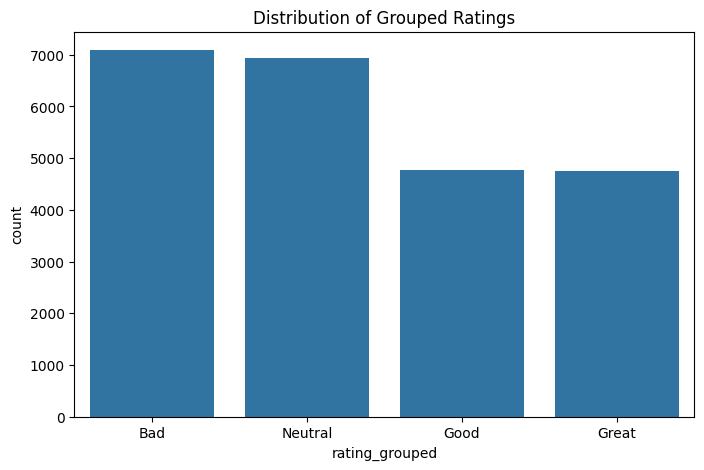

In [32]:
### Step 2: Group Ratings

def group_ratings(row):
    if row['rating'] == 1:
        return 'Bad'
    elif row['rating'] in [2, 3]:
        return 'Neutral'
    elif row['rating'] == 4:
        return 'Good'
    elif row['rating'] == 5:
        return 'Great'

combined_df['rating_grouped'] = combined_df.apply(group_ratings, axis=1)

# Visualize grouped ratings
plt.figure(figsize=(8, 5))
sns.countplot(data=combined_df, x='rating_grouped', order=['Bad', 'Neutral', 'Good', 'Great'])
plt.title("Distribution of Grouped Ratings")
plt.show()

# Predicting Ratings Using Classical ML Models
This section focuses on predicting star ratings using text reviews. We'll extract TF-IDF features and train models like Logistic Regression and Random Forest. The performance will be evaluated using metrics such as accuracy, F1-score, and confusion matrix.

Classification Report for Ratings:
              precision    recall  f1-score   support

         Bad       0.64      0.75      0.69      1450
        Good       0.48      0.44      0.46       939
       Great       0.59      0.60      0.60       932
     Neutral       0.46      0.40      0.43      1387

    accuracy                           0.56      4708
   macro avg       0.54      0.55      0.54      4708
weighted avg       0.55      0.56      0.55      4708



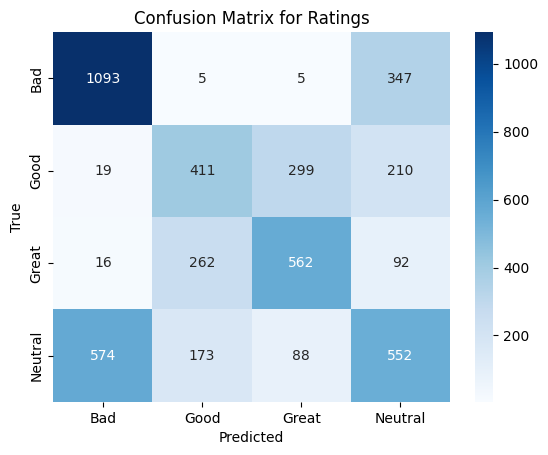

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# TF-IDF Feature Extraction
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(combined_df['review'])
y_ratings = combined_df['rating_grouped']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_ratings, test_size=0.2, random_state=42)

# Logistic Regression for Ratings
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluation
print("Classification Report for Ratings:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Ratings")
plt.show()

# Predicting Product Categories Using Classical ML Models
In this section, we predict the product category associated with each review. We'll use TF-IDF for feature extraction and train models like Logistic Regression and Random Forest. The evaluation focuses on metrics such as accuracy and confusion matrices.

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report for Products:
                         precision    recall  f1-score   support

      accidental injury       0.80      0.37      0.51       154
                animals       1.00      0.16      0.28        75
                    car       0.73      0.98      0.84      2679
                 credit       0.84      0.22      0.34       120
                 health       0.82      0.74      0.78       690
                   home       0.84      0.44      0.58       427
                   life       0.84      0.40      0.54       129
             motorcycle       0.92      0.26      0.41       427
 professional liability       0.00      0.00      0.00         1
professional multi-risk       0.00      0.00      0.00         4
      ten-year warranty       0.00      0.00      0.00         2

               accuracy                           0.76      4708
              macro avg       0.62      0.32      0.39      4708
           weighted avg       0.78      0.76      0.

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

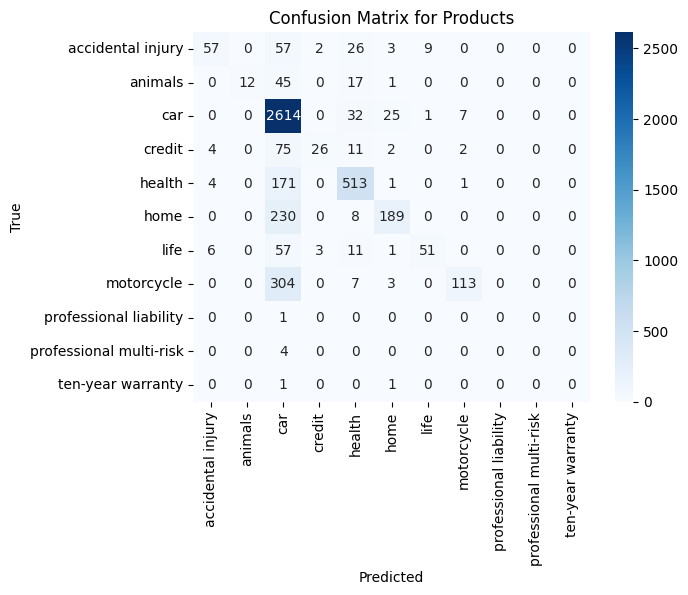

In [34]:
# Labels for Products
y_products = combined_df['product']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_products, test_size=0.2, random_state=42)

# Logistic Regression for Products
lr_product = LogisticRegression(max_iter=1000, multi_class="ovr")
lr_product.fit(X_train, y_train)
y_pred_product = lr_product.predict(X_test)

# Evaluation
print("Classification Report for Products:")
print(classification_report(y_test, y_pred_product))

# Confusion Matrix
cm_product = confusion_matrix(y_test, y_pred_product, labels=lr_product.classes_)
sns.heatmap(cm_product, annot=True, fmt="d", cmap="Blues", xticklabels=lr_product.classes_, yticklabels=lr_product.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Products")
plt.show()

In [35]:
### Step 3: Upsample Underrepresented Products with Paraphrasing
from transformers import pipeline
import random

def augment_reviews_with_paraphrasing_batched(df, product_column, review_column, target_count, batch_size=10):
    paraphraser = pipeline("text2text-generation", model="t5-small", device=-1)

    augmented_data = []

    for product, group in df.groupby(product_column):
        deficit = max(0, target_count - len(group))
        if deficit == 0:
            continue

        reviews_to_augment = random.choices(group[review_column].tolist(), k=deficit)

        # Batch processing
        for i in range(0, len(reviews_to_augment), batch_size):
            batch = reviews_to_augment[i : i + batch_size]
            try:
                paraphrased = paraphraser(
                    [f"paraphrase: {review}" for review in batch],
                    max_length=60,
                    num_return_sequences=1,
                    truncation=True,
                )
                augmented_data.extend(
                    {
                        product_column: product,
                        review_column: result["generated_text"],
                        "rating_grouped": group["rating_grouped"].iloc[0],
                    }
                    for result in paraphrased
                )
            except Exception as e:
                print(f"Error during paraphrasing batch: {e}")
                continue

    return pd.DataFrame(augmented_data)

# Determine the target count for underrepresented products
median_count = combined_df["product"].value_counts().median()

# Apply the function to upsample
augmented_reviews = augment_reviews_with_paraphrasing_batched(
    combined_df, "product", "review", int(median_count)
)

# Combine the augmented data with the original dataframe
augmented_df = pd.concat([combined_df, augmented_reviews], ignore_index=True)

print("Data Shape After Augmentation:", augmented_df.shape)

Device set to use cpu


Data Shape After Augmentation: (25781, 5)


In [37]:
### Step 4: Verify Distribution After Augmentation
print("Product Distribution After Augmentation:")
print(augmented_df["product"].value_counts())
augmented_df.to_csv("augmented_reviews.csv", index=False)

Product Distribution After Augmentation:
product
car                        13745
health                      3443
motorcycle                  2063
home                        1922
accidental injury            768
life                         640
ten-year warranty            640
animals                      640
credit                       640
professional multi-risk      640
professional liability       640
Name: count, dtype: int64


In [38]:
### Step 5: Modeling Preparation
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(augmented_df['review'])

# Encode labels for grouped ratings and products
from sklearn.preprocessing import LabelEncoder

rating_encoder = LabelEncoder()
product_encoder = LabelEncoder()

augmented_df['rating_encoded'] = rating_encoder.fit_transform(augmented_df['rating_grouped'])
augmented_df['product_encoded'] = product_encoder.fit_transform(augmented_df['product'])

# Split data
from sklearn.model_selection import train_test_split

# For ratings prediction
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, augmented_df['rating_encoded'], test_size=0.2, random_state=42)

# For product prediction
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, augmented_df['product_encoded'], test_size=0.2, random_state=42)

In [39]:
### Step 6: Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Logistic Regression for Ratings
clf_ratings = LogisticRegression(max_iter=500)
clf_ratings.fit(X_train_r, y_train_r)
ratings_pred = clf_ratings.predict(X_test_r)
print("Classification Report for Ratings:")
print(classification_report(y_test_r, ratings_pred, target_names=rating_encoder.classes_))

# Logistic Regression for Products
clf_products = LogisticRegression(max_iter=500)
clf_products.fit(X_train_p, y_train_p)
products_pred = clf_products.predict(X_test_p)
print("Classification Report for Products:")
print(classification_report(y_test_p, products_pred, target_names=product_encoder.classes_))


Classification Report for Ratings:
              precision    recall  f1-score   support

         Bad       0.70      0.81      0.75      1791
        Good       0.47      0.46      0.46       929
       Great       0.60      0.60      0.60       962
     Neutral       0.49      0.40      0.44      1475

    accuracy                           0.59      5157
   macro avg       0.56      0.57      0.56      5157
weighted avg       0.58      0.59      0.58      5157

Classification Report for Products:
                         precision    recall  f1-score   support

      accidental injury       0.82      0.46      0.59       160
                animals       0.93      0.33      0.49       120
                    car       0.76      0.97      0.85      2726
                 credit       0.78      0.24      0.37       120
                 health       0.82      0.75      0.78       701
                   home       0.81      0.51      0.63       396
                   life       0.91    